# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [104]:
# Recommended versions:
import os, zipfile, random, shutil
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

Load the dataset.

In [105]:
# Load and unzip the dataset

ZIP_PATH  = Path("data.zip")       # adjust if needed
DATA_ROOT = Path("data")
DATA_ROOT.mkdir(parents=True, exist_ok=True)

if not any(DATA_ROOT.iterdir()):
    with zipfile.ZipFile(ZIP_PATH) as zf:
        zf.extractall(DATA_ROOT)

DATA_ROOT = Path("data/data")
# Sanity counts
img_ext = {".jpg", ".jpeg", ".png"}
counts = Counter(p.parent.name for p in DATA_ROOT.glob("*/*") if p.suffix.lower() in img_ext)
print("📊 Images per class:", counts)



📊 Images per class: Counter({'Plastic': 2295, 'Paper': 1030, 'Other': 1010, 'Food_Waste': 1000, 'Metal': 1000, 'Glass': 750, 'Cardboard': 540})


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [106]:
# Create a function to load the raw images

def load_images(path: Path, img_size=(224,224)):
    """Return numpy array X, list y where y is the folder name."""
    X, y = [], []
    for img_path in path.glob("*/*"):
        if img_path.suffix.lower() not in img_ext: continue
        img = Image.open(img_path).convert("RGB").resize(img_size)
        X.append(np.asarray(img))
        y.append(img_path.parent.name)
    return np.array(X), y

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [107]:
# Get the images and their labels

IMG_SIZE  = (224,224)
BATCH     = 32
VAL_SPLIT = 0.2
SEED      = 123
DATA_ROOT = Path("data/data")

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_ROOT, validation_split=VAL_SPLIT, subset="training", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH, label_mode="int")     # integer labels
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_ROOT, validation_split=VAL_SPLIT, subset="validation", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH, label_mode="int")

class_names = train_ds.class_names
print("Classes:", class_names)

Found 7625 files belonging to 7 classes.
Using 6100 files for training.
Found 7625 files belonging to 7 classes.
Using 1525 files for validation.
Classes: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

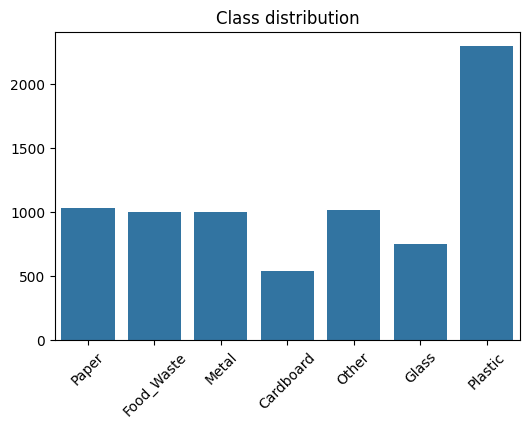

In [108]:
# Visualise Data Distribution

# 2.2.1 class distribution bar
plt.figure(figsize=(6,4))
sns.barplot(x=list(counts.keys()), y=list(counts.values()))
plt.xticks(rotation=45); plt.title("Class distribution"); plt.show()


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

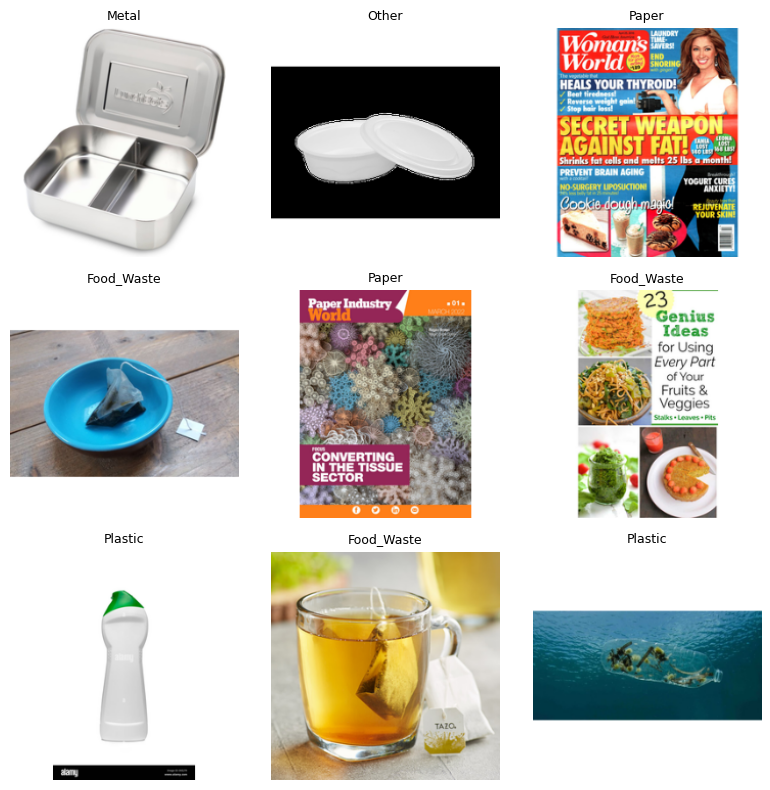

In [109]:
# Visualise Sample Images (across different labels)

plt.figure(figsize=(8,8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]], fontsize=9); plt.axis("off")
plt.tight_layout(); plt.show()


#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [110]:

DATA_ROOT = Path("data/data")
img_paths = [p for p in DATA_ROOT.glob("*/*") if p.suffix in img_ext]
print("Found", len(img_paths), "images.")
shapes = [Image.open(p).size for p in img_paths]
mins = np.min(shapes, axis=0)
maxs = np.max(shapes, axis=0)
print("Min (w,h):", mins, "Max (w,h):", maxs)

Found 7625 images.
Min (w,h): [256 256] Max (w,h): [256 256]


In [111]:
# Resize the image dimensions

TARGET_SIZE = (224, 224)        # (height, width)

def resize_batch(images, labels):
    images = tf.image.resize(images, TARGET_SIZE)   # bilinear by default
    return images, labels

# Wrap train & val datasets with the resize → normalise pipeline
train_ds = (
    train_ds
    .map(resize_batch, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),  # normalise
         num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    val_ds
    .map(resize_batch, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
         num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

print("✅  All batches will now yield images of shape", TARGET_SIZE, "normalised to [0,1].")

✅  All batches will now yield images of shape (224, 224) normalised to [0,1].


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [112]:
# Encode the labels suitably

label2idx = {cls:i for i,cls in enumerate(class_names)}
print(label2idx)

{'Cardboard': 0, 'Food_Waste': 1, 'Glass': 2, 'Metal': 3, 'Other': 4, 'Paper': 5, 'Plastic': 6}


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [113]:
# Assign specified parts of the dataset to train and validation sets

test_ds = val_ds.take(int(len(val_ds)*0.5))
val_ds  = val_ds.skip(int(len(val_ds)*0.5))

## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [116]:
# Build and compile the model
model = tf.keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(7)  # no softmax if using logits
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [117]:
# Training
rlr   = callbacks.ReduceLROnPlateau(patience=3, factor=0.3, min_lr=1e-6)
early = callbacks.EarlyStopping(patience=8, restore_best_weights=True)
ckpt  = callbacks.ModelCheckpoint("best_model.keras", save_best_only=True,
                                  monitor="val_accuracy")

history = model.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds,
                    callbacks=[rlr, early, ckpt])

Epoch 1/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 87s 449ms/step - accuracy: 0.3012 - loss: 1.8233 - val_accuracy: 0.3355 - val_loss: 1.7521 - learning_rate: 0.0010
Epoch 2/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 93s 485ms/step - accuracy: 0.3616 - loss: 1.6736 - val_accuracy: 0.3421 - val_loss: 1.6607 - learning_rate: 0.0010
Epoch 3/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 90s 469ms/step - accuracy: 0.3774 - loss: 1.6146 - val_accuracy: 0.3699 - val_loss: 1.6738 - learning_rate: 0.0010
Epoch 4/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 93s 488ms/step - accuracy: 0.4106 - loss: 1.5641 - val_accuracy: 0.3831 - val_loss: 1.5694 - learning_rate: 0.0010
Epoch 5/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 102s 530ms/step - accuracy: 0.4232 - loss: 1.5365 - val_accuracy: 0.3831 - val_loss: 1.5856 - learning_rate: 0.0010
Epoch 6/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 103s 537ms/step - accuracy: 0.4308 - loss: 1.5096 - val_accuracy: 0.4029 - val_loss: 1.5375 - learning_rate: 0.0010
Epoch 7/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 101s 527ms/step - accuracy: 

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

24/24 - 3s - 122ms/step - accuracy: 0.5641 - loss: 1.1975
0.5640686750411987


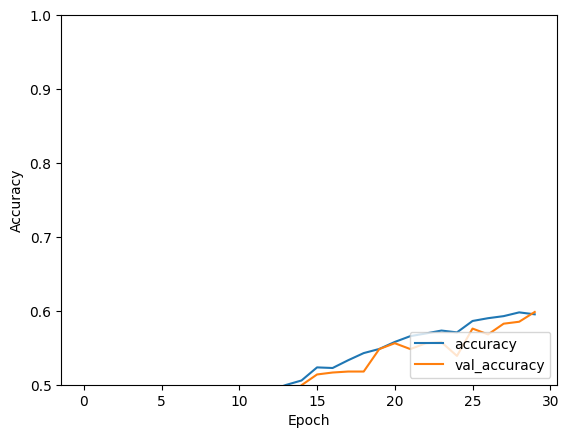

In [120]:
# Evaluate on the test set; display suitable metrics
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(val_ds, verbose=2)
print(test_acc)

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [121]:
# Define augmentation steps to augment images

aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [125]:
# Create a function to augment the images
augmenter = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1),
], name="augmenter")

def augment_batch(images, labels):
    images = augmenter(images, training=True)   # force augmentation
    return images, labels

In [126]:
# Create the augmented training dataset
aug_train_ds = (
    train_ds
    .map(augment_batch,  num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

##### **4.1.2**

Train the model on the new augmented dataset.

In [127]:
# Train the model using augmented images
history_aug = model.fit(
    aug_train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[ckpt, early]
)


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 89s 460ms/step - accuracy: 0.5353 - loss: 1.2661 - val_accuracy: 0.5376 - val_loss: 1.2920
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 101s 524ms/step - accuracy: 0.5357 - loss: 1.2703 - val_accuracy: 0.5192 - val_loss: 1.2941
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 108s 564ms/step - accuracy: 0.5450 - loss: 1.2509 - val_accuracy: 0.5310 - val_loss: 1.3020
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 94s 487ms/step - accuracy: 0.5517 - loss: 1.2454 - val_accuracy: 0.5152 - val_loss: 1.3350
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 90s 466ms/step - accuracy: 0.5608 - loss: 1.2032 - val_accuracy: 0.5324 - val_loss: 1.2984
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 90s 470ms/step - accuracy: 0.5527 - loss: 1.2155 - val_accuracy: 0.5099 - val_loss: 1.3392
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 91s 471ms/step - accuracy: 0.5556 - loss: 1.2056 - val_accuracy: 0.5205 - val_loss: 1.2681
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 92s 477ms/step - accuracy: 0.5639 - loss:

24/24 - 3s - 130ms/step - accuracy: 0.5416 - loss: 1.2045
0.5416116118431091


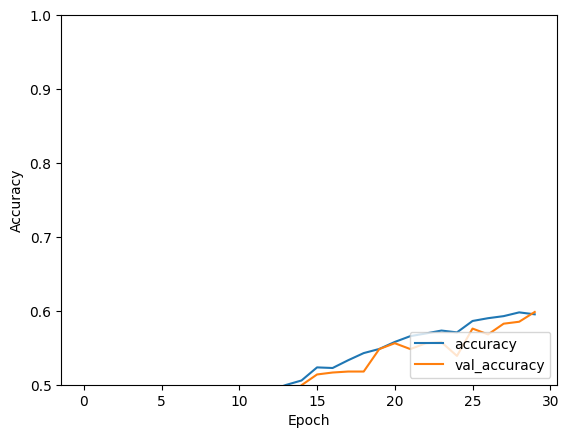

In [128]:

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(val_ds, verbose=2)
print(test_acc)




## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

#### Findings from the data

#### Number of classes: 7

#### Class labels: 0 to 6
{'Cardboard': 0, 'Food_Waste': 1, 'Glass': 2, 'Metal': 3, 'Other': 4, 'Paper': 5, 'Plastic': 6}

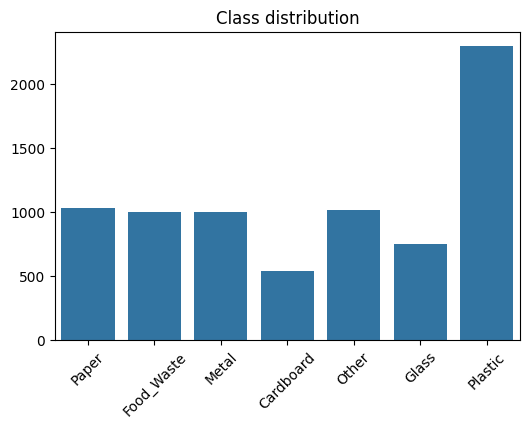


#### Sample images

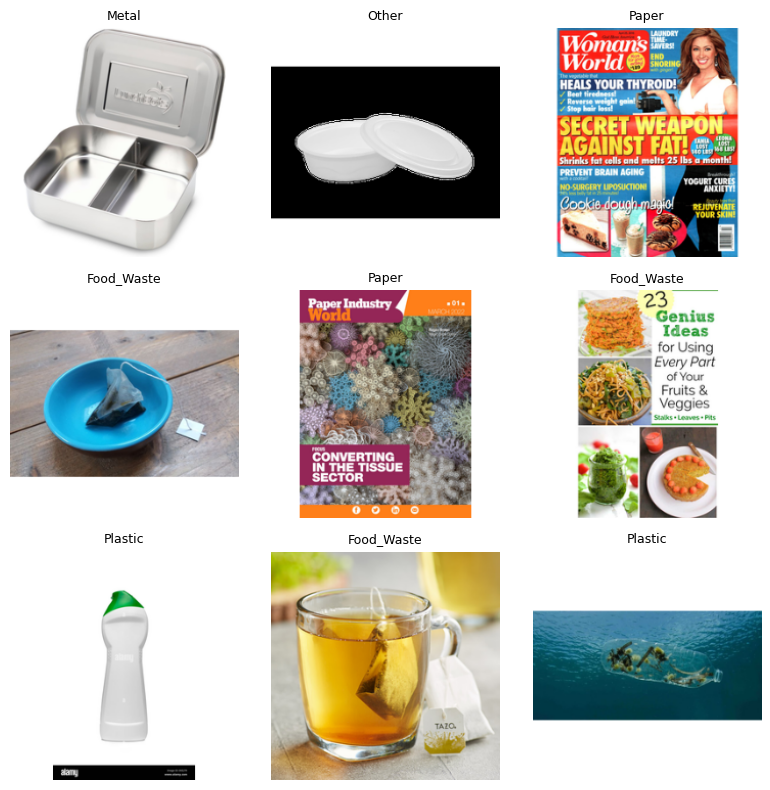


#### Image size: 
Resized to (224, 224, 3)



#### Model Training Results

##### Model Trained with

Optimizer: Adam

Loss Function: SparseCategoricalCrossentropy (from logits)

Batch size: 32

Epochs: 30

##### Model accuracy

accuracy: 0.5641 - loss: 1.1975

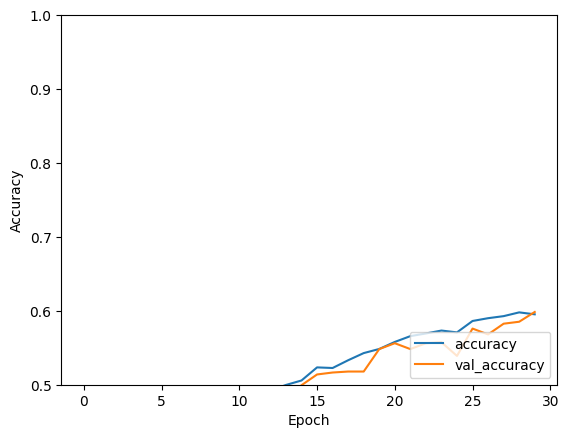


